In [6]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sys import path
path.append('../../')
from kooplearn.estimators import ReducedRank
from kooplearn.kernels import RBF, Matern

from Logistic import LogisticMap
from Lorenz63 import Lorenz63

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 9
})

### Benchmarks plot

In [7]:
data = [ pickle.load(open(f"data/{fname}_randSVD_benchmarks.pkl", "rb")) for fname in ['logistic_map', 'lorenz63']]
titles = ['Logistic map', 'Lorenz63']

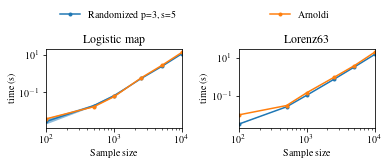

In [9]:
fig_width = 5.5 #Inches
fig_height = 2 #Inches

#Hardcoded
n_oversamples = data[0]['n_oversamples']
iterated_power = data[0]['iterated_power']

fig, axes = plt.subplots(ncols=len(data), figsize=(fig_width, fig_height))

for idx in range(len(data)):
    results = data[idx]
    ax = axes[idx]
    solvers = results['solvers']
    means = results['means']
    stds = results['stds']
    iter_arr = results['iterated_array']

    for solver_idx, solver in enumerate(solvers):
        if solver == 'randomized':
            label = solver.capitalize() + f" p={iterated_power}, s={n_oversamples}"
        else:
            label = solver.capitalize()
        if idx == 0:
            ax.plot(iter_arr, means[solver_idx], '.-', label=label)
        else:
            ax.plot(iter_arr, means[solver_idx], '.-')
        ax.fill_between(iter_arr, (means - stds)[solver_idx], (means + stds)[solver_idx], alpha=0.5)
    ax.set_ylabel("time (s)")
    ax.set_xlabel("Sample size")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(titles[idx])
    ax.set_xmargin(0)

fig.legend(bbox_to_anchor=(0.15, 1, 0.7, 0.2), borderaxespad=0, loc='lower center', mode='expand', ncol=3, frameon=False)
plt.tight_layout()
#fig.savefig("figs/randomizedSVD_benchmarks.pdf",  bbox_inches='tight')

### Estimator consistency check: Lorenz63

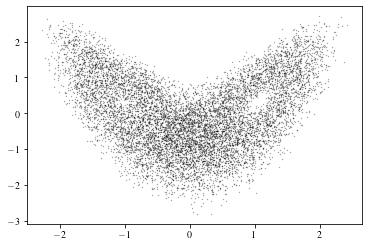

In [2]:
params = {
    #Lorenz63
    'kernel': Matern(length_scale=1.0, nu = 0.5),
    'backend': 'numpy',
    'rank': 5,
    'tikhonov_reg': 1e-6,
    'n_oversamples': 5,
    'iterated_power': 3
}
map = Lorenz63(dt = 0.1, seed=0)

sample_size = 10000

x, y = map.sample(size=sample_size)
x = (x - x.mean(axis=0)) / x.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)

plt.scatter(x[:,0], x[:,2], s=0.1, alpha=0.5, color='k')

In [3]:
rand_estimator = ReducedRank(**params, svd_solver='randomized').fit(x,y)
estimator = ReducedRank(**params, svd_solver='arnoldi').fit(x,y)

In [12]:
rand_estimator.eig(left=False, right=False)

array([0.63152262+0.70167027j, 0.63152262-0.70167027j,
       0.93796691+0.j        , 0.7736204 +0.11852352j,
       0.7736204 -0.11852352j])

In [11]:
estimator.eig(left=False, right = False)

array([0.63206475+0.67564656j, 0.63206475-0.67564656j,
       0.9486878 +0.j        , 0.76310522+0.08502848j,
       0.76310522-0.08502848j])